This is a LSTM forecasting for "RUB/USD", "Oil", "Gas", and "MOEX" indexies. As was previously analysed (Johnson, Jaya. 2023. Machine Learning for Financial Market Forecasting. Master's thesis, Harvard University Division of Continuing Education.) a LSTM-based forecasting is not accurate, and SVM and traditional technical analysis overpower.

MOEX is one of the central indexies, it describes the country's market. It depends on the prices of gas and oil, as well as the ruble exchange rate.

Economics is irrational, it also depends on psychology. Therefore, it is better to use technical analysis in the intervals between major events, and include fundamental analysis in the case of extraordinary ones. And this is still a probabilistic scenario.

Here is a neural network consisting of LSTM blocks with a different number of hidden parameters. The analysis is carried out over a 40-day window (2 working months, the range is taken from the technical analysis). In my subjective opinion, this setting showed the best. Again, this is purely my subjective opinion.

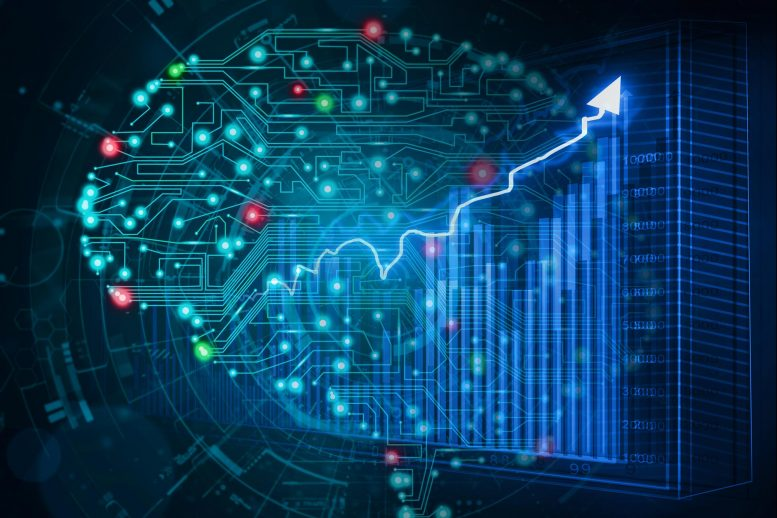

Import libraries

In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn

import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 14.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=727579 sha256=0ee5e484d2e6ec6b0abbbc9d0ff9a37e3fa14920c762a5fecaaf4bb6c6fa29e5
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built peewee


Import yfinance

In [3]:
# To fetch financial data
import yfinance as yf

Choose the periods and check the data

In [4]:
period = '10y'
interval = '1d'

In [5]:
# Set the ticker as 'RUB=X=X'
forex_data = yf.download('RUB=X', period=period, interval=interval)

# Set the index to a datetime object
forex_data.index = pd.to_datetime(forex_data.index)

# Display the last five rows
forex_data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,92.269997,92.269997,92.269997,92.269997,92.269997,0
2024-04-29,92.269997,92.269997,92.269997,92.269997,92.269997,0
2024-04-30,93.419998,93.419998,93.419998,93.419998,93.419998,0
2024-05-01,93.419998,93.419998,93.419998,93.419998,93.419998,0
2024-05-02,93.513000,94.001198,90.978996,91.911903,91.911903,0


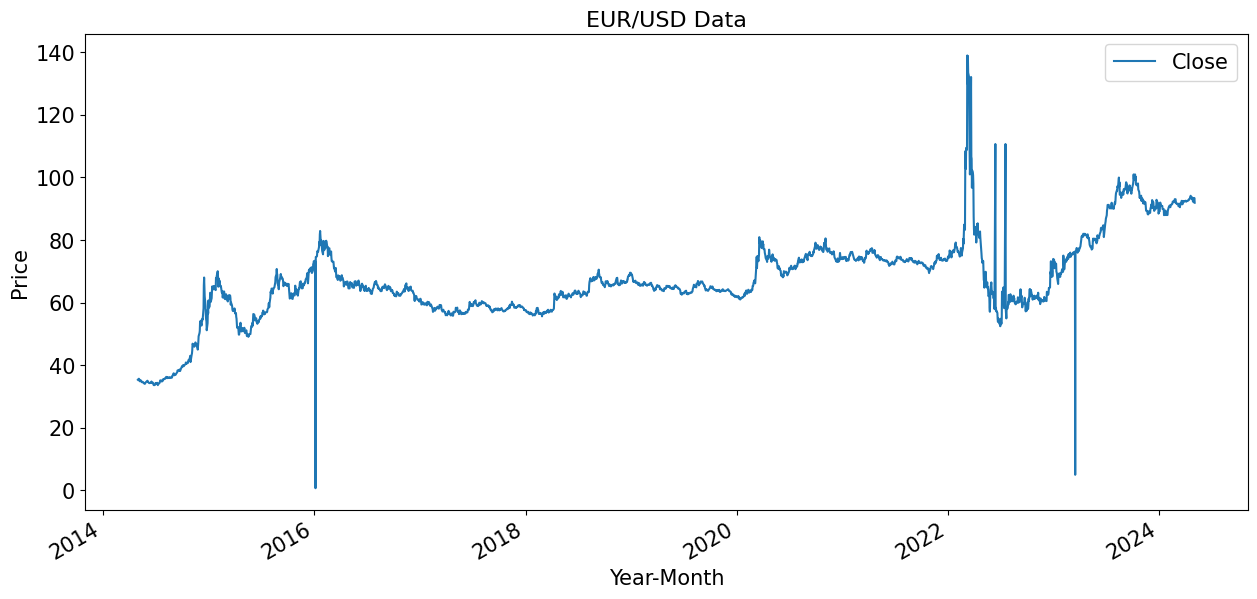

In [6]:
# Plot the close price
plt.figure(figsize=(15, 7))
forex_data['Close'].plot()

# Set the title and axis label
plt.title('EUR/USD Data', fontsize=16)
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Show the plot
plt.show()

In [7]:
forex_data[(forex_data['Close']>100)|(forex_data['Close']<30)]['Close']

Date
2016-01-06      0.716200
2022-03-01    104.973503
2022-03-02    108.479500
2022-03-03    102.714996
2022-03-04    109.464996
2022-03-07    108.845100
2022-03-08    138.965103
2022-03-09    129.964996
2022-03-10    138.714996
2022-03-11    133.464996
2022-03-14    132.088699
2022-03-15    119.964996
2022-03-16    108.277496
2022-03-17    100.965103
2022-03-18    103.089996
2022-03-21    132.088699
2022-03-22    106.614998
2022-03-23    105.964996
2022-03-25    102.214996
2022-03-28    100.839996
2022-06-13    110.674103
2022-07-18    110.674103
2023-03-16      5.000000
2023-10-04    100.964996
2023-10-06    100.089996
2023-10-09    100.964996
2023-10-11    100.264801
Name: Close, dtype: float64

In [8]:
forex_data.loc['2022-06-13','Close'] = (forex_data.loc['2022-06-10','Close']+forex_data.loc['2022-06-14','Close'])/2
forex_data.loc['2022-06-13','Close']

57.84000015258789

In [9]:
forex_data.loc['2022-07-18','Close'] = (forex_data.loc['2022-07-15','Close']+forex_data.loc['2022-07-19','Close'])/2
forex_data.loc['2022-07-18','Close']

57.977500915527344

In [10]:
forex_data.loc['2023-03-16','Close'] = (forex_data.loc['2023-03-15','Close']+forex_data.loc['2023-03-17','Close'])/2
forex_data.loc['2023-03-16','Close']

76.08999633789062

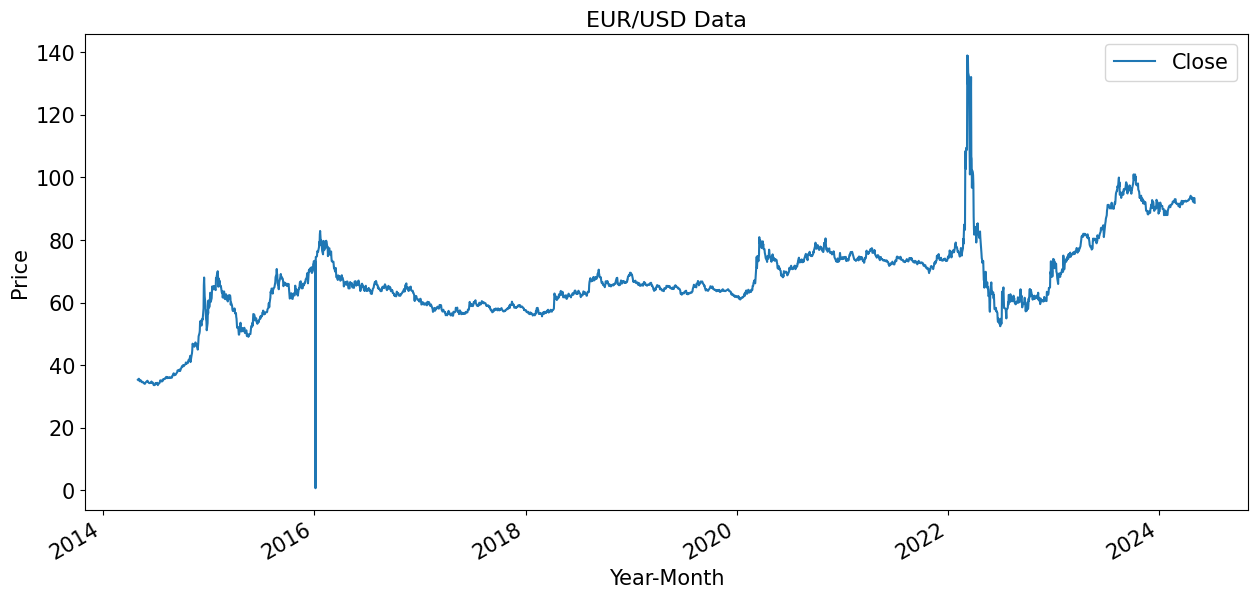

In [11]:
# Plot the close price
plt.figure(figsize=(15, 7))
forex_data['Close'].plot()

# Set the title and axis label
plt.title('EUR/USD Data', fontsize=16)
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Show the plot
plt.show()

In [12]:
# Set the ticker as 'RUB=X'
forex_data_1 = yf.download('BZ=F', period=period, interval=interval)

# Set the index to a datetime object
forex_data_1.index = pd.to_datetime(forex_data_1.index)

# Display the last five rows
forex_data_1.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,89.209999,89.830002,88.800003,89.500000,89.500000,15475
2024-04-29,89.250000,89.300003,88.099998,88.400002,88.400002,15093
2024-04-30,88.320000,88.709999,87.470001,87.860001,87.860001,39816
2024-05-01,85.959999,85.959999,83.290001,83.440002,83.440002,39816
2024-05-02,83.559998,84.419998,83.419998,83.620003,83.620003,13457


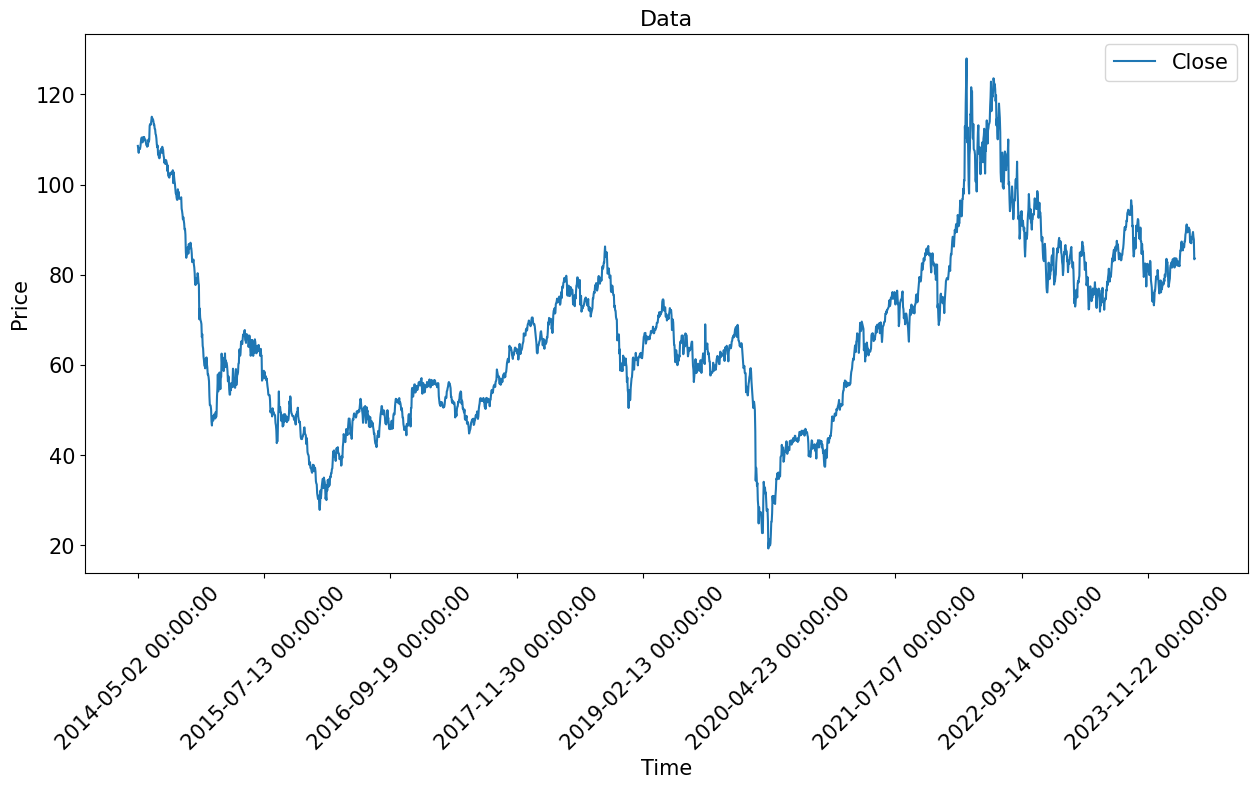

In [13]:
# Transform index type from datetime to string
forex_data_1['dates'] = forex_data_1.index.strftime(
    '%Y-%m-%d %H:%M:%S')

# Plot the series
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(forex_data_1['dates'], forex_data_1['Close'])

# Set title and axis label
plt.title('Data', fontsize=16)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Set maximum number of tick locators
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [14]:
# Set the ticker as 'RUB=X'
forex_data_2 = yf.download('NG=F', period=period, interval=interval)

# Set the index to a datetime object
forex_data_2.index = pd.to_datetime(forex_data_2.index)

# Display the last five rows
forex_data_2.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,1.622,1.628,1.482,1.614,1.614,119516
2024-04-29,1.923,2.056,1.916,2.030,2.030,158855
2024-04-30,2.050,2.092,1.951,1.991,1.991,150370
2024-05-01,1.954,1.970,1.913,1.932,1.932,150370
2024-05-02,1.931,1.988,1.927,1.966,1.966,28831


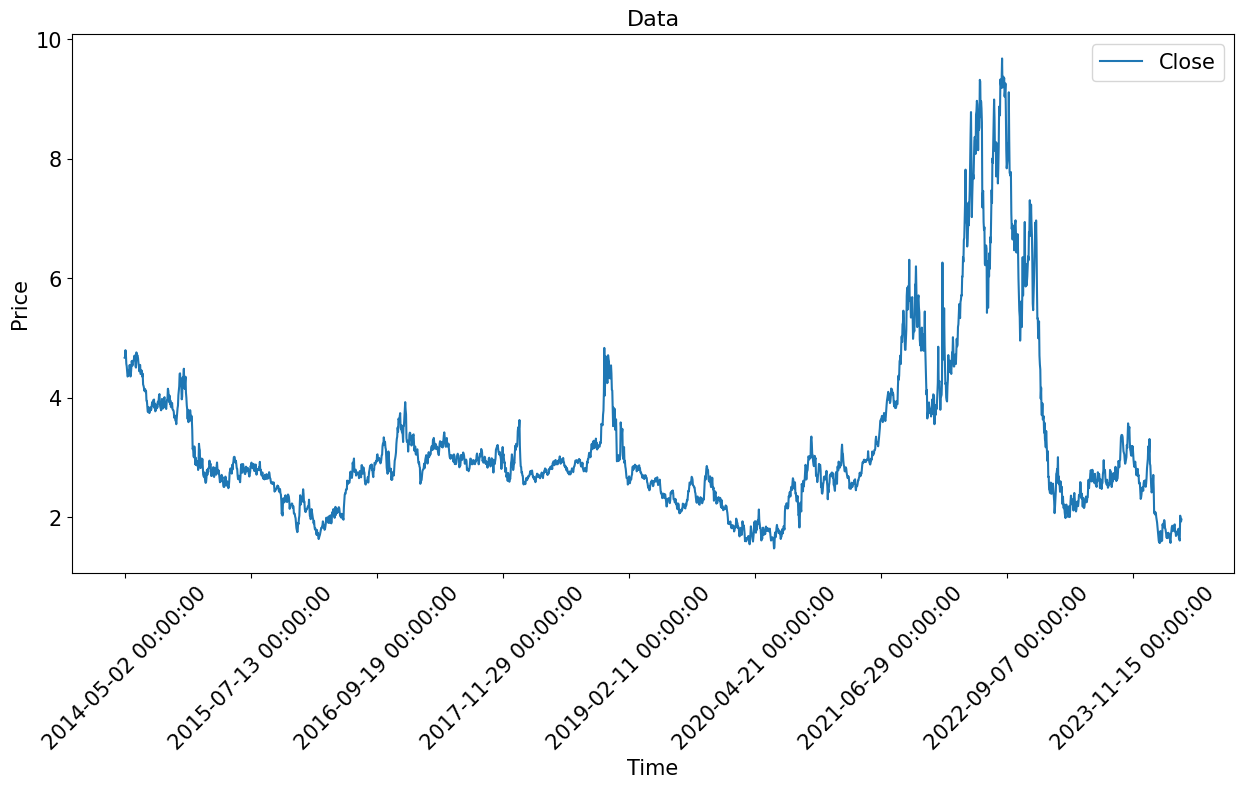

In [15]:
# Transform index type from datetime to string
forex_data_2['dates'] = forex_data_2.index.strftime(
    '%Y-%m-%d %H:%M:%S')

# Plot the series
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(forex_data_2['dates'], forex_data_2['Close'])

# Set title and axis label
plt.title('Data', fontsize=16)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Set maximum number of tick locators
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [16]:
forex_data_3 = yf.download('IMOEX.ME', period=period, interval=interval)

# Set the index to a datetime object
forex_data_3.index = pd.to_datetime(forex_data_3.index)

# Display the last five rows
forex_data_3.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-24,3438.449951,3445.669922,3423.169922,3428.929932,3428.929932,0
2024-04-25,3429.620117,3443.739990,3427.020020,3439.760010,3439.760010,0
2024-04-26,3446.389893,3459.120117,3438.060059,3449.770020,3449.770020,0
2024-04-29,3468.919922,3480.469971,3467.250000,3478.080078,3478.080078,0
2024-04-30,3481.290039,3486.300049,3464.860107,3469.830078,3469.830078,0


In [17]:
def display(data, pred = None, vert = None, title = 'Prediction'):
  data = np.array(data).reshape((len(data), 1))
  plt.figure(figsize=(12, 6))
  plt.plot(data, label='Some periodic function')
  if pred != None:
    plt.plot(pred, label=title)
  if vert != None:
    plt.axvline(x=vert, c='r', linestyle='--')
  plt.legend()
  plt.grid()
  plt.show()

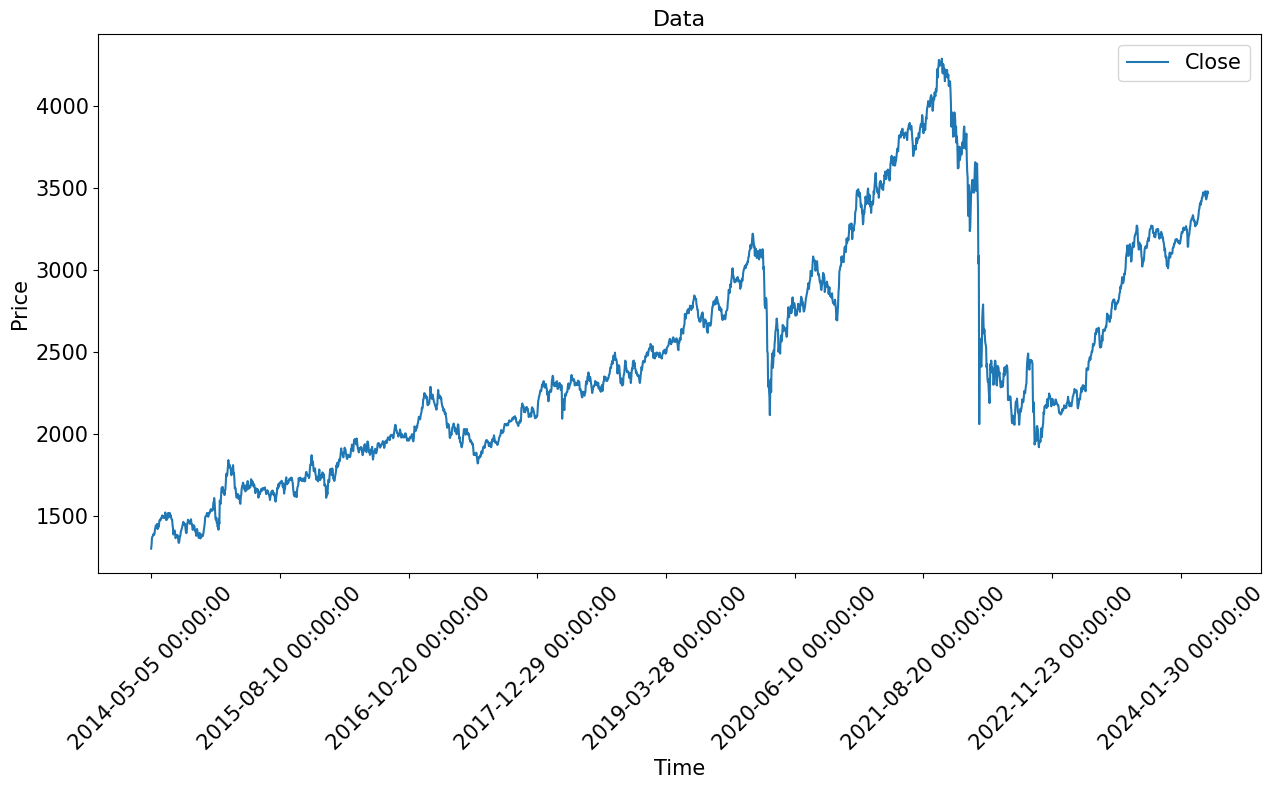

In [18]:
# Transform index type from datetime to string
forex_data_3['dates'] = forex_data_3.index.strftime(
    '%Y-%m-%d %H:%M:%S')

# Plot the series
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(forex_data_3['dates'], forex_data_3['Close'])

# Set title and axis label
plt.title('Data', fontsize=16)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Set maximum number of tick locators
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [19]:
df1 = forex_data[['Close']].rename(columns={'Close': 'dollar'})
df2 = forex_data_1[['Close']].rename(columns={'Close': 'oil'})
df3 = forex_data_2[['Close']].rename(columns={'Close': 'gas'})
df4 = forex_data_3[['Close']].rename(columns={'Close': 'MOEX'})
df = pd.merge(df1,df2, how='inner', left_index=True, right_index=True)
df = pd.merge(df,df3, how='inner', left_index=True, right_index=True)
df = pd.merge(df,df4, how='inner', left_index=True, right_index=True)
df

,dollar,oil,gas,MOEX
Date,,,,
2014-05-05,35.666199,107.720001,4.688,1298.290039
2014-05-06,35.655998,107.059998,4.799,1318.569946
2014-05-07,35.403198,108.129997,4.740,1363.479980
2014-05-08,34.893200,108.040001,4.572,1371.420044
2014-05-12,35.181198,108.410004,4.434,1375.310059
...,...,...,...,...
2024-04-24,93.019997,88.019997,1.653,3428.929932
2024-04-25,93.470001,89.010002,1.638,3439.760010
2024-04-26,92.269997,89.500000,1.614,3449.770020


In [20]:
train_size = int(len(df)-20)

train_data = df[:train_size].to_numpy()

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
train_df = scaler1.fit_transform(train_data)


In [22]:
input_size = 4
hidden_size = 40
num_classes = 4


In [23]:
set_random_seed(42)
import warnings
warnings.filterwarnings('ignore')

# create data "ensemble"
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)] # picking several sequential observations
        _y = data[i+seq_length] # picking the subsequent observation
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

# set length of the ensemble; accuracy of the predictions and
# speed perfomance almost always depend on it size
seq_length =  40 # compare 2 and 32
x, y = sliding_windows(train_df, seq_length)
print("Example of the obtained data:\n")
print("Data corresponding to the first x:")
print(x[0])
print("Data corresponding to the first y:")
print(y[0])


x_train = x
y_train = y




# Define new LSTM based model
class LSTMPredictor(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        # hidden_size == number of neurons
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//2, batch_first=True, dropout=0.2)
        self.lstm3 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//4, batch_first=True, dropout=0.2)
        self.lstm4 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//8, batch_first=True, dropout=0.2)
        self.fc_1 = nn.Linear(4*hidden_size, 64) # fully connected
        self.fc_11 = nn.Linear(64, 64)
        self.a = hidden_size + hidden_size//2 + hidden_size//4 + hidden_size//8
        self.fc_2 = nn.Linear(self.a, 1) # fully connected
        self.fc_3 = nn.Linear(self.a, 1) # fully connected
        self.fc_4 = nn.Linear(self.a, 1) # fully connected
        self.fc_5 = nn.Linear(self.a, 1) # fully connected
        self.relu = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        out, (h1, c) = self.lstm1(x)
        out, (h2, c) = self.lstm2(x)
        out, (h3, c) = self.lstm3(x)
        out, (h4, c) = self.lstm4(x)

        out1 = torch.cat((h1, h2, h3, h4), 2)
        #out1 = self.drop(self.fc_11(self.drop(self.fc_1(self.relu(out)))))
        out2 = self.fc_2(self.relu(out1))
        out3 = self.fc_3(self.relu(out1))
        out4 = self.fc_4(self.relu(out1))
        out5 = self.fc_5(self.relu(out1))

        return torch.cat((out2, out3, out4, out5), 2)

lstm =  LSTMPredictor(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)


lstm.train()

print("LSTM training process with MSE loss:")

num_epochs = 2000
learning_rate = 0.001

criterion = torch.nn.L1Loss() # mean-squared error for regression
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

 # Train the model
for epoch in range(num_epochs):
    y_pred = lstm(x_train)
    optimizer.zero_grad()
    #print(outputs.shape)
    loss = criterion(y_pred, y_train.unsqueeze(0))
    loss.backward()

    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

Example of the obtained data:

Data corresponding to the first x:
tensor([[0.3443, 0.8479, 0.3911, 0.0000],
        [0.3442, 0.8415, 0.4046, 0.0068],
        [0.3417, 0.8518, 0.3974, 0.0218],
        [0.3367, 0.8509, 0.3769, 0.0245],
        [0.3396, 0.8545, 0.3601, 0.0258],
        [0.3377, 0.8624, 0.3508, 0.0291],
        [0.3356, 0.8716, 0.3519, 0.0304],
        [0.3338, 0.8740, 0.3644, 0.0280],
        [0.3353, 0.8738, 0.3575, 0.0314],
        [0.3344, 0.8637, 0.3645, 0.0387],
        [0.3330, 0.8668, 0.3745, 0.0426],
        [0.3328, 0.8750, 0.3648, 0.0474],
        [0.3306, 0.8732, 0.3509, 0.0442],
        [0.3311, 0.8749, 0.3566, 0.0471],
        [0.3295, 0.8699, 0.3687, 0.0398],
        [0.3315, 0.8679, 0.3827, 0.0427],
        [0.3331, 0.8694, 0.3753, 0.0499],
        [0.3340, 0.8641, 0.3733, 0.0447],
        [0.3364, 0.8585, 0.3818, 0.0556],
        [0.3366, 0.8584, 0.3839, 0.0584],
        [0.3383, 0.8544, 0.3852, 0.0594],
        [0.3372, 0.8581, 0.3927, 0.0577],
        [0

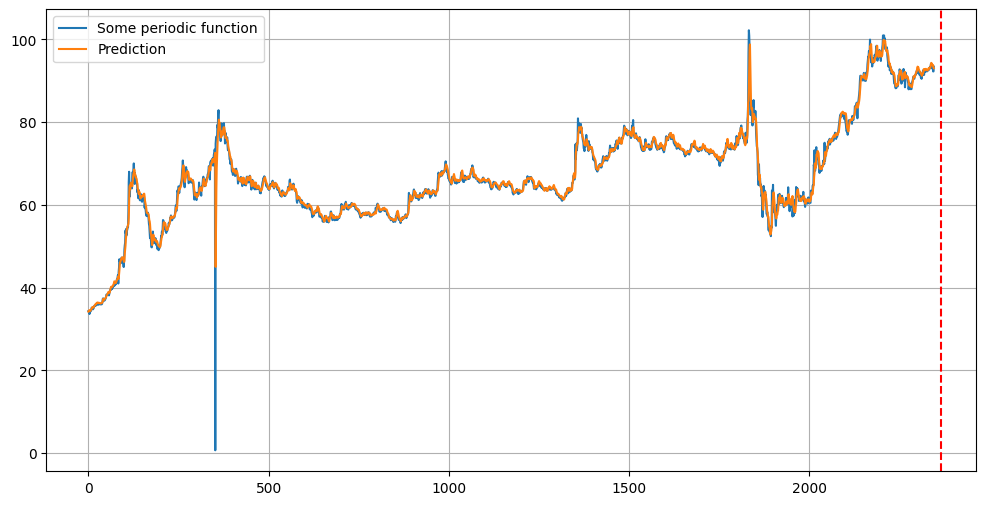

In [24]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,0], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,0]), vert=train_size)

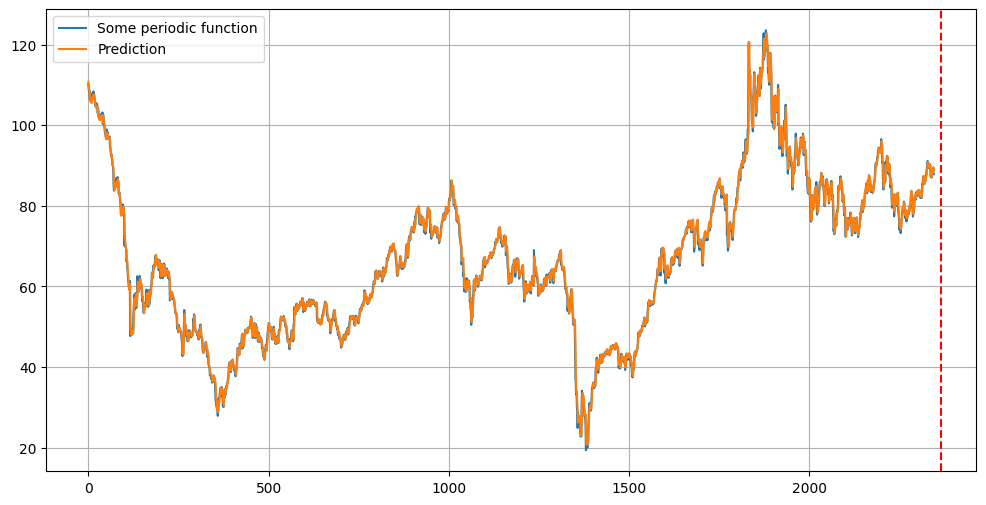

In [25]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,1], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,1]), vert=train_size)

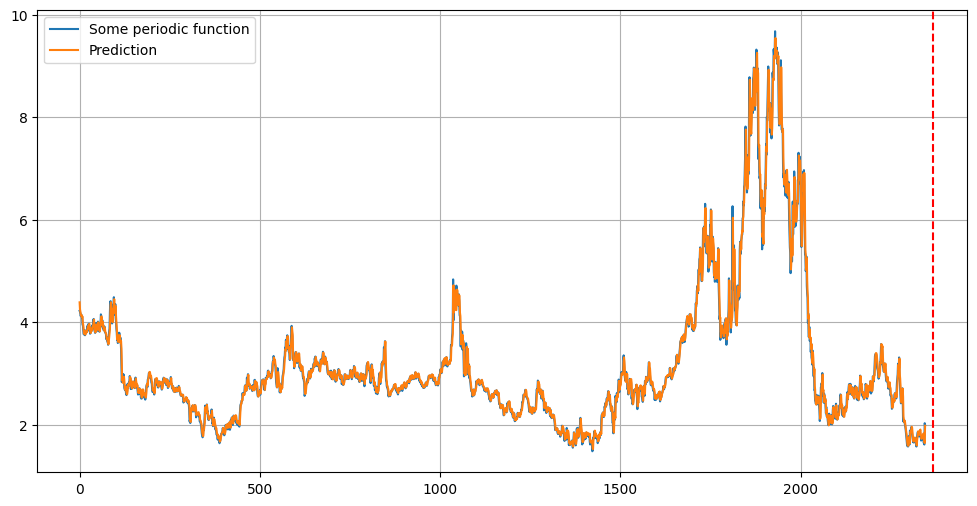

In [26]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,2], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,2]), vert=train_size)

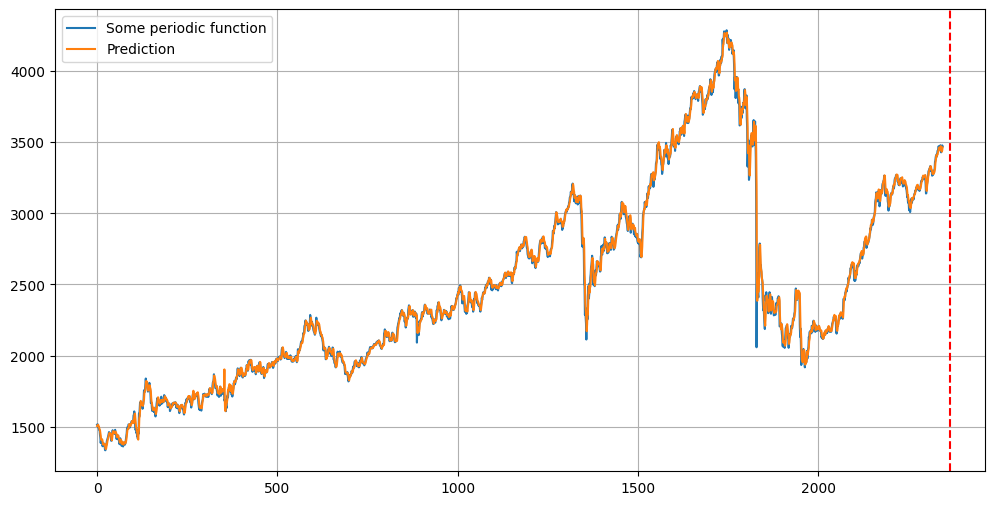

In [27]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,3], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,3]), vert=train_size)

In [28]:
data_pred = scaler1.transform(df.to_numpy().reshape(-1,num_classes))

x_s, y_s = sliding_windows(data_pred, seq_length)
for i in range(20):
    data_pred = np.append(data_pred, (lstm(x_s).detach().numpy()[0][-1]).reshape(-1,num_classes),  axis=0)
    x_s, y_s = sliding_windows(data_pred, seq_length)
data_pred

array([[0.34433905, 0.8478657 , 0.391071  , 0.        ],
       [0.34423855, 0.84153473, 0.40461084, 0.00678432],
       [0.34174788, 0.85179852, 0.39741396, 0.02180827],
       ...,
       [0.93056965, 0.67046201, 0.0921355 , 0.71823758],
       [0.93151581, 0.67117941, 0.09387123, 0.71797305],
       [0.93247533, 0.67159522, 0.09582328, 0.71772009]])

In [29]:
df[-20:]

,dollar,oil,gas,MOEX
Date,,,,
2024-04-03,92.279999,89.349998,1.841,3395.590088
2024-04-04,92.449997,90.650002,1.774,3407.570068
2024-04-05,92.449997,91.169998,1.785,3395.370117
2024-04-08,92.570000,90.379997,1.844,3417.379883
2024-04-09,92.620003,89.419998,1.872,3414.260010
2024-04-10,92.620003,90.480003,1.885,3439.110107
2024-04-11,92.889999,89.739998,1.764,3439.530029
2024-04-12,92.889999,90.449997,1.770,3456.239990
2024-04-15,93.300003,90.099998,1.691,3472.189941


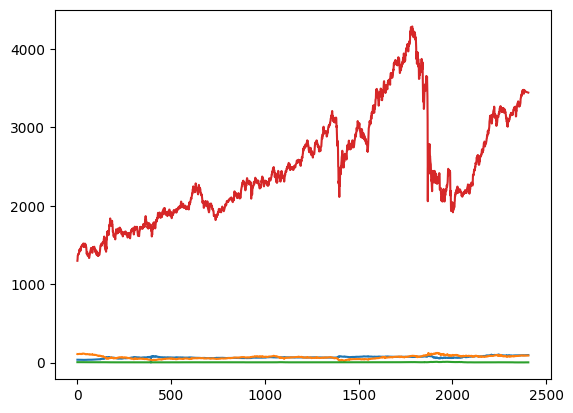

In [30]:
plt.plot(scaler1.inverse_transform(data_pred.reshape(-1,num_classes)))

Train on all data, except len(forex_data)*0.01

In [31]:
train_size = int(len(df))

train_data = df[:train_size].to_numpy()
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
train_df = scaler1.fit_transform(train_data)


set_random_seed(42)
import warnings
warnings.filterwarnings('ignore')

# create data "ensemble"
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)] # picking several sequential observations
        _y = data[i+seq_length] # picking the subsequent observation
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

# set length of the ensemble; accuracy of the predictions and
# speed perfomance almost always depend on it size
seq_length = 40 # compare 2 and 32
x, y = sliding_windows(train_df, seq_length)
print("Example of the obtained data:\n")
print("Data corresponding to the first x:")
print(x[0])
print("Data corresponding to the first y:")
print(y[0])


x_train = x
y_train = y




# Define new LSTM based model
class LSTMPredictor(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        # hidden_size == number of neurons
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//2, batch_first=True, dropout=0.2)
        self.lstm3 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//4, batch_first=True, dropout=0.2)
        self.lstm4 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//8, batch_first=True, dropout=0.2)
        self.fc_1 = nn.Linear(4*hidden_size, 64) # fully connected
        self.fc_11 = nn.Linear(64, 64)
        self.a = hidden_size + hidden_size//2 + hidden_size//4 + hidden_size//8
        self.fc_2 = nn.Linear(self.a, 1) # fully connected
        self.fc_3 = nn.Linear(self.a, 1) # fully connected
        self.fc_4 = nn.Linear(self.a, 1) # fully connected
        self.fc_5 = nn.Linear(self.a, 1) # fully connected
        self.relu = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        out, (h1, c) = self.lstm1(x)
        out, (h2, c) = self.lstm2(x)
        out, (h3, c) = self.lstm3(x)
        out, (h4, c) = self.lstm4(x)

        out1 = torch.cat((h1, h2, h3, h4), 2)
        #out1 = self.drop(self.fc_11(self.drop(self.fc_1(self.relu(out)))))
        out2 = self.fc_2(self.relu(out1))
        out3 = self.fc_3(self.relu(out1))
        out4 = self.fc_4(self.relu(out1))
        out5 = self.fc_5(self.relu(out1))

        return torch.cat((out2, out3, out4, out5), 2)

lstm =  LSTMPredictor(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

lstm.train()

print("LSTM training process with MSE loss:")

num_epochs = 2000
learning_rate = 0.001

criterion = torch.nn.L1Loss() # mean-squared error for regression
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

 # Train the model
for epoch in range(num_epochs):
    y_pred = lstm(x_train)
    optimizer.zero_grad()
    #print(outputs.shape)
    loss = criterion(y_pred, y_train.unsqueeze(0))
    loss.backward()

    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

Example of the obtained data:

Data corresponding to the first x:
tensor([[0.3443, 0.8479, 0.3911, 0.0000],
        [0.3442, 0.8415, 0.4046, 0.0068],
        [0.3417, 0.8518, 0.3974, 0.0218],
        [0.3367, 0.8509, 0.3769, 0.0245],
        [0.3396, 0.8545, 0.3601, 0.0258],
        [0.3377, 0.8624, 0.3508, 0.0291],
        [0.3356, 0.8716, 0.3519, 0.0304],
        [0.3338, 0.8740, 0.3644, 0.0280],
        [0.3353, 0.8738, 0.3575, 0.0314],
        [0.3344, 0.8637, 0.3645, 0.0387],
        [0.3330, 0.8668, 0.3745, 0.0426],
        [0.3328, 0.8750, 0.3648, 0.0474],
        [0.3306, 0.8732, 0.3509, 0.0442],
        [0.3311, 0.8749, 0.3566, 0.0471],
        [0.3295, 0.8699, 0.3687, 0.0398],
        [0.3315, 0.8679, 0.3827, 0.0427],
        [0.3331, 0.8694, 0.3753, 0.0499],
        [0.3340, 0.8641, 0.3733, 0.0447],
        [0.3364, 0.8585, 0.3818, 0.0556],
        [0.3366, 0.8584, 0.3839, 0.0584],
        [0.3383, 0.8544, 0.3852, 0.0594],
        [0.3372, 0.8581, 0.3927, 0.0577],
        [0

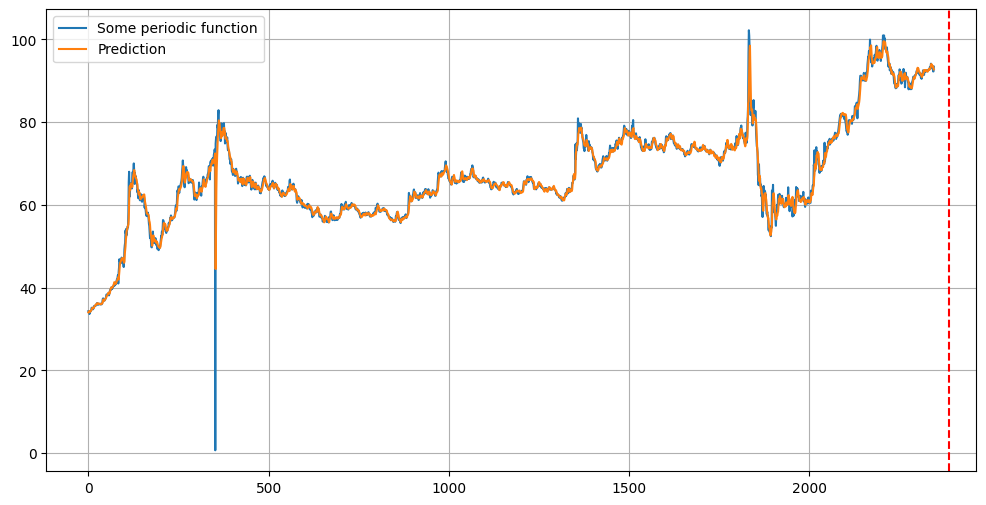

In [32]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,0], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,0]), vert=train_size)

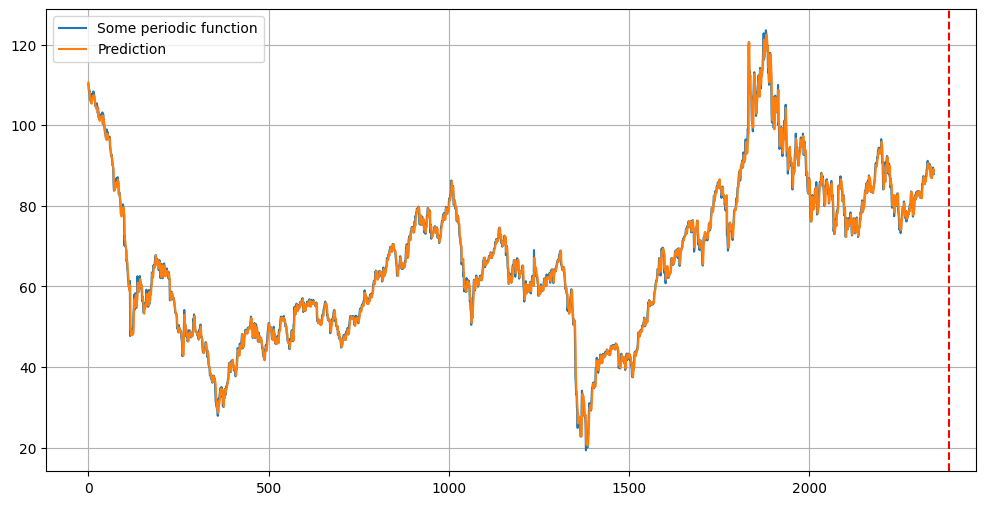

In [33]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,1], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,1]), vert=train_size)

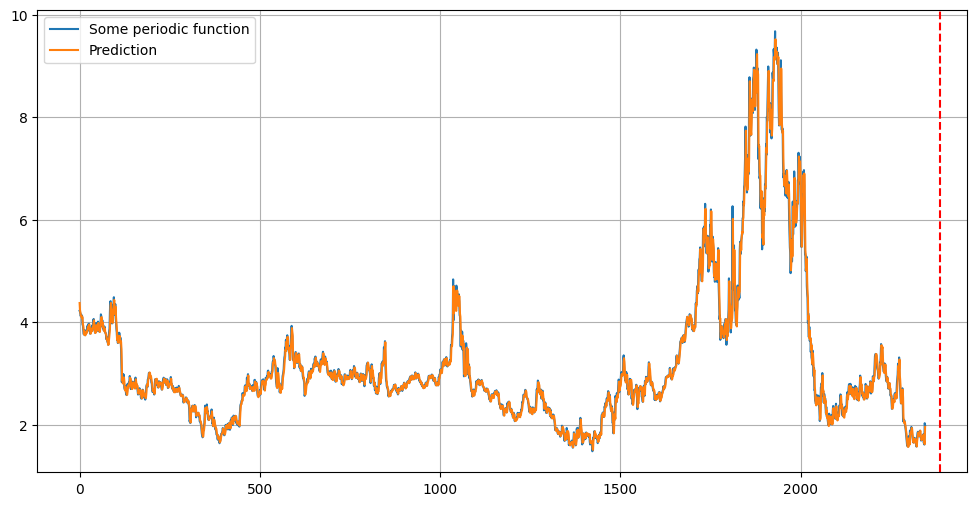

In [34]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,2], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,2]), vert=train_size)

In [35]:
data_pred = scaler1.transform(df[:-20].to_numpy().reshape(-1,num_classes))

x_s, y_s = sliding_windows(data_pred, seq_length)
for i in range(20):
    data_pred = np.append(data_pred, (lstm(x_s).detach().numpy()[0][-1]).reshape(-1,num_classes),  axis=0)
    x_s, y_s = sliding_windows(data_pred, seq_length)
data_pred

array([[0.34433905, 0.8478657 , 0.391071  , 0.        ],
       [0.34423855, 0.84153473, 0.40461084, 0.00678432],
       [0.34174788, 0.85179852, 0.39741396, 0.02180827],
       ...,
       [0.9113121 , 0.64230537, 0.04125158, 0.72129452],
       [0.91181064, 0.64132559, 0.04120237, 0.72263521],
       [0.91225457, 0.6408397 , 0.04133062, 0.72390586]])

In [36]:
df[-20:]

,dollar,oil,gas,MOEX
Date,,,,
2024-04-03,92.279999,89.349998,1.841,3395.590088
2024-04-04,92.449997,90.650002,1.774,3407.570068
2024-04-05,92.449997,91.169998,1.785,3395.370117
2024-04-08,92.570000,90.379997,1.844,3417.379883
2024-04-09,92.620003,89.419998,1.872,3414.260010
2024-04-10,92.620003,90.480003,1.885,3439.110107
2024-04-11,92.889999,89.739998,1.764,3439.530029
2024-04-12,92.889999,90.449997,1.770,3456.239990
2024-04-15,93.300003,90.099998,1.691,3472.189941


In [37]:
pd.DataFrame(scaler1.inverse_transform(data_pred.reshape(-1,num_classes))[-(20):-1])

,0,1,2,3
0,92.469035,87.327367,1.815849,3361.497643
1,92.312999,88.466627,1.848686,3383.177967
2,92.604472,87.290495,1.819956,3383.037924
3,92.516938,87.957631,1.841679,3392.853776
4,92.682696,87.142868,1.821921,3396.104167
5,92.638823,87.546739,1.835592,3402.065624
6,92.737350,87.004511,1.822394,3406.426562
7,92.727846,87.245407,1.830736,3411.108743
8,92.801127,86.879478,1.821934,3415.775068
9,92.817056,87.010042,1.826828,3420.090215


In [38]:
data_pred = scaler1.transform(df.to_numpy().reshape(-1,num_classes))

x_s, y_s = sliding_windows(data_pred, seq_length)
for i in range(20):
    data_pred = np.append(data_pred, (lstm(x_s).detach().numpy()[0][-1]).reshape(-1,num_classes),  axis=0)
    x_s, y_s = sliding_windows(data_pred, seq_length)
data_pred

array([[0.34433905, 0.8478657 , 0.391071  , 0.        ],
       [0.34423855, 0.84153473, 0.40461084, 0.00678432],
       [0.34174788, 0.85179852, 0.39741396, 0.02180827],
       ...,
       [0.91189778, 0.64664841, 0.06657431, 0.74442863],
       [0.91199774, 0.64620852, 0.06688015, 0.74524087],
       [0.91213065, 0.64553523, 0.0674708 , 0.7460295 ]])

In [39]:
pd.DataFrame(scaler1.inverse_transform(data_pred.reshape(-1,num_classes))[-(20):-1])

,0,1,2,3
0,92.766256,88.571839,1.957292,3475.679520
1,93.230699,87.886185,1.990473,3474.459042
2,93.051256,88.176208,1.972195,3481.103432
3,93.172966,87.679602,1.995375,3482.095137
4,93.095087,87.847995,1.983048,3487.153618
5,93.149075,87.510773,1.999094,3489.440990
6,93.113672,87.608355,1.990918,3493.347411
7,93.150079,87.372069,2.002394,3496.031750
8,93.137671,87.416597,1.997304,3499.330783
9,93.166940,87.241977,2.005942,3502.100823


In [40]:
df_pred = scaler1.inverse_transform(data_pred.reshape(-1,num_classes))
df_pred

array([[3.56661987e+01, 1.07720001e+02, 4.68800020e+00, 1.29829004e+03],
       [3.56559982e+01, 1.07059998e+02, 4.79899979e+00, 1.31856995e+03],
       [3.54031982e+01, 1.08129997e+02, 4.73999977e+00, 1.36347998e+03],
       ...,
       [9.32727269e+01, 8.67430976e+01, 2.02777623e+00, 3.52355843e+03],
       [9.32828724e+01, 8.66972399e+01, 2.03028350e+00, 3.52598638e+03],
       [9.32963635e+01, 8.66270489e+01, 2.03512560e+00, 3.52834378e+03]])

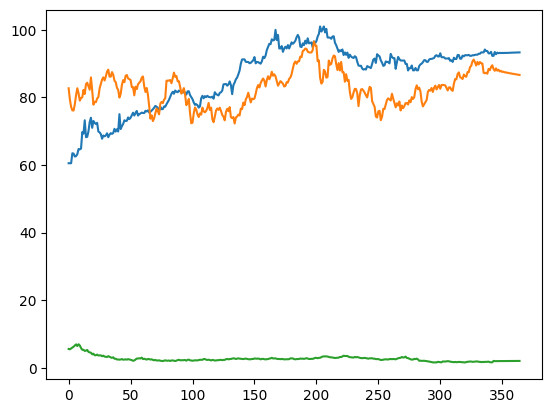

In [41]:
plt.plot(df_pred[-365:,0:3])

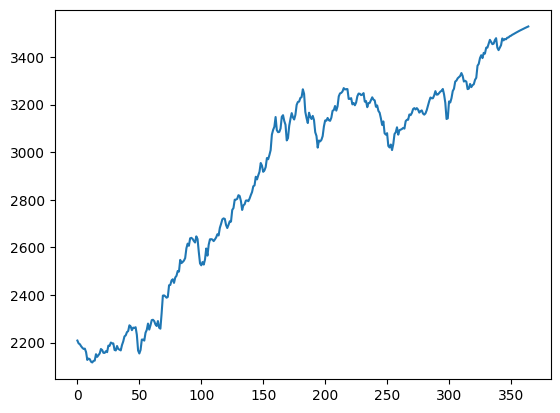

In [42]:
plt.plot(df_pred[-365:,3])